<h1><center> Deep learning Speech to Text conversion </center></h1>

# Lesson Goals

<div style="text-align: Justify"> Build a speech recognition system that understands simple spoken commands. </div>


______
# Prerequests 
  1. Install Librosa
  2. Install Keras, tensorflow 2.2
  3. Install sounddevice

In [2]:
pip install librosa

Note: you may need to restart the kernel to use updated packages.


<h2>Import the libraries<h2>

In [3]:
import os
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")

<h2>Data Exploration and Visualization<h2>

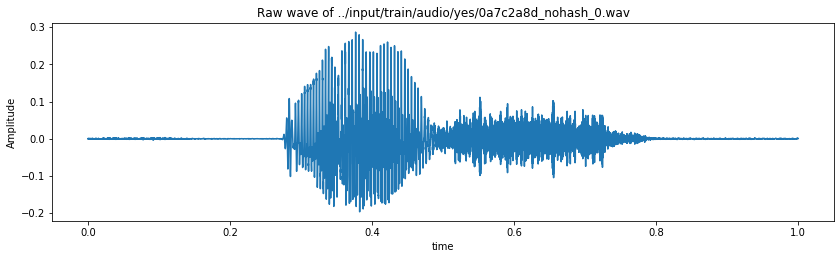

In [4]:
train_audio_path = 'C:/Users/agurm/Downloads/tensorflow/train/train/audio/'
samples, sample_rate = librosa.load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + '../input/train/audio/yes/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

***Sampling rate***

In [5]:
ipd.Audio(samples, rate=sample_rate)
print(sample_rate)

16000


***Resampling***
<div text-align = justify>From the above, we can understand that the sampling rate of the signal is 16,000 Hz. Let us re-sample it to 8000 Hz since most of the speech-related frequencies are present at 8000 Hz</div>

In [6]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

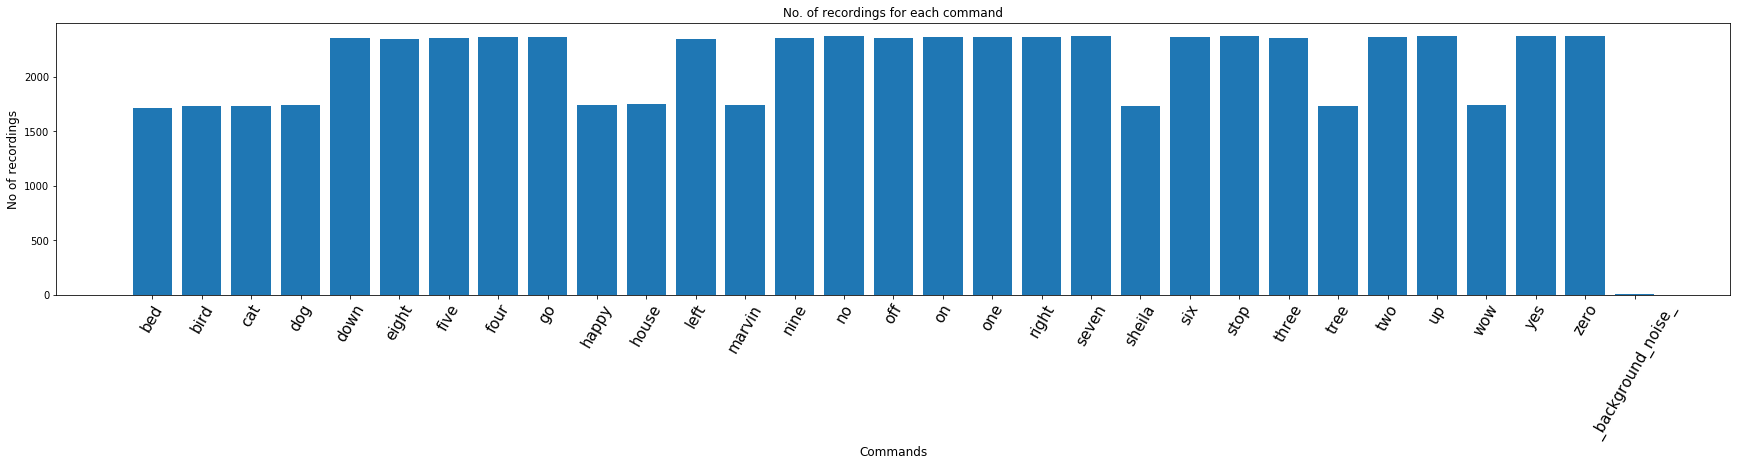

In [7]:
labels=os.listdir(train_audio_path)

#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

***Duration of recordings***

(array([1.5000e+01, 3.0000e+01, 4.4000e+01, 1.3800e+02, 1.3600e+02,
        1.7900e+02, 3.6600e+02, 4.3400e+02, 5.9300e+02, 2.1747e+04]),
 array([0.418 , 0.4762, 0.5344, 0.5926, 0.6508, 0.709 , 0.7672, 0.8254,
        0.8836, 0.9418, 1.    ]),
 <a list of 10 Patch objects>)

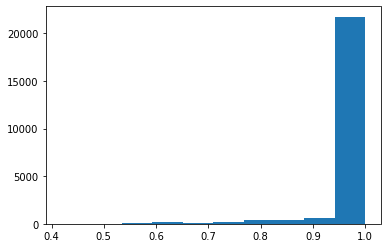

In [8]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

***Preprocessing the audio waves***

Here are the two steps we’ll follow:

1. Resampling
2. Removing shorter commands of less than 1 second

In [9]:
all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

yes
no
up
down
left
right
on
off
stop
go


***Prepare a multi-classification audio wave into one hot vector***


In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

In [11]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [13]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

In [14]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

***Data Splitting into train and Test dataset***

In [15]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

***Training our model***

In [16]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)          

In [17]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [18]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [19]:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Epoch 1/100
533/533 [==============================] - 173s 324ms/step - loss: 2.0466 - accuracy: 0.2284 - val_loss: 1.5947 - val_accuracy: 0.4082
Epoch 2/100
533/533 [==============================] - 180s 338ms/step - loss: 1.4633 - accuracy: 0.4682 - val_loss: 1.1635 - val_accuracy: 0.6050
Epoch 3/100
533/533 [==============================] - 180s 338ms/step - loss: 1.1712 - accuracy: 0.5935 - val_loss: 0.9623 - val_accuracy: 0.6812
Epoch 4/100
533/533 [==============================] - 181s 340ms/step - loss: 0.9428 - accuracy: 0.6778 - val_loss: 0.7662 - val_accuracy: 0.7467
Epoch 5/100
533/533 [==============================] - 181s 339ms/step - loss: 0.8202 - accuracy: 0.7188 - val_loss: 0.7679 - val_accuracy: 0.7427
Epoch 6/100
533/533 [==============================] - 180s 337ms/step - loss: 0.7431 - accuracy: 0.7444 - val_loss: 0.6452 - val_accuracy: 0.7793
Epoch 7/100
533/533 [==============================] - 180s 337ms/step - loss: 0.6937 - accuracy: 0.7600 - val_loss: 0

533/533 [==============================] - 183s 343ms/step - loss: 0.3638 - accuracy: 0.8760 - val_loss: 0.5171 - val_accuracy: 0.8398
Epoch 28/100
533/533 [==============================] - 180s 338ms/step - loss: 0.3363 - accuracy: 0.8847 - val_loss: 0.5661 - val_accuracy: 0.8266
Epoch 29/100
533/533 [==============================] - 179s 335ms/step - loss: 0.3224 - accuracy: 0.8903 - val_loss: 0.5147 - val_accuracy: 0.8344
Epoch 30/100
533/533 [==============================] - 179s 336ms/step - loss: 0.3366 - accuracy: 0.8869 - val_loss: 0.4870 - val_accuracy: 0.8414
Epoch 31/100
533/533 [==============================] - 181s 339ms/step - loss: 0.3217 - accuracy: 0.8909 - val_loss: 0.5128 - val_accuracy: 0.8358
Epoch 32/100
533/533 [==============================] - 179s 337ms/step - loss: 0.3097 - accuracy: 0.8924 - val_loss: 0.5054 - val_accuracy: 0.8433
Epoch 33/100
533/533 [==============================] - 180s 338ms/step - loss: 0.3112 - accuracy: 0.8920 - val_loss: 0.5521 

***Model Validation***

we validate our model using test dataset using plot

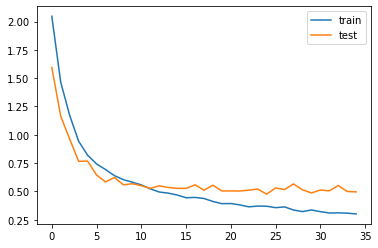

In [20]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

***Loading the best model***

from keras.models import load_model


In [27]:
from keras.models import load_model

model = load_model('model.h5')

In [22]:
model.save("model.h5")

In [23]:
from keras.models import load_model

model = load_model('model.h5')

In [24]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [25]:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)
print("Text:",predict(samples))

Audio: on
Text: on


In [28]:
pip install sounddevice

Note: you may need to restart the kernel to use updated packages.


In [34]:
import sounddevice as sd
import soundfile as sf

samplerate = 16000  
duration = 1 # seconds
filename = 'yes.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

start
end


In [36]:
os.listdir('C:/Users/agurm/Downloads/tensorflow/train/train/audio/stop')
filepath='C:/Users/agurm/Downloads/tensorflow/train/train/audio/stop'

#reading the voice commands
samples, sample_rate = librosa.load(filepath + '/' + 'stop.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)  

predict(samples)

'stop'

In [42]:
audio = 'C:/Users/agurm/Downloads/tensorflow/train/train/audio/right/'
sa, sa_rate = librosa.load(audio+'right.wav', sr = 16000)
ash=librosa.resample(sa, sa_rate, 8000)
ipd.Audio(ash, rate=8000)

In [43]:
train_audio = 'C:/Users/agurm/Downloads/tensorflow/train/train/audio/left/'
samp, samp_rate = librosa.load(train_audio+'left.wav', sr = 16000)
samp = librosa.resample(samp, samp_rate, 8000)
ipd.Audio(samp,rate=8000)  



In [44]:
predict(samp)

'yes'

In [49]:
audio1 = 'C:/Users/agurm/Downloads/tensorflow/train/train/audio/'

In [51]:
all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(audio1 + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sampl, sampl_rate = librosa.load(audio1 + '/' + label + '/' + wav, sr = 16000)
        sampp = librosa.resample(sampl, sampl_rate, 8000)
        if(len(sampp)== 8000) : 
            all_wave.append(sampp)
            all_label.append(label)

yes
no
up
down
left
right
on
off
stop
go


***Record your voice to test the model***

In [60]:
import sounddevice as sd
import soundfile as sf

samplerate = 16000  
duration = 1 # seconds
filename = 'right.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

start
end


In [61]:
os.listdir('C:/Users/agurm/Downloads/')
filepath='C:/Users/agurm/Downloads/'
samples, sample_rate = librosa.load(filepath + 'right.wav', sr = 16000)
sample = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)


<div text-align : "justify">Here the prediction fail due to my system takes 3 second to record my voice where our model developed to encode 1 second duration. i will work on it further</div>

# Further reading

1.SpeechPy - A Library for Speech Processing and Recognition [link](https://www.researchgate.net/publication/323571435_SpeechPy_-_A_Library_for_Speech_Processing_and_Recognition).

2.Python For Audio Signal Processing [link](http://mural.maynoothuniversity.ie/4115/1/40.pdf).
 
3.Programming Real-Time Sound in Python [link](https://www.mdpi.com/2076-3417/10/12/4214/htm)
 
 ______
##  Conclusion

In this tutorial, you learned how to develop audio signal to text conversion model and validate the saved model using test data & your own voice.

Specifically, you learned:

* How to read audio and preprocess it.
* How to prepare an audio signal to train model.
* How to Save the model.
* How to test the saved model with your own voice.

# Next Step
There is still much room to improve the model. For example, you can try more options like training a model with different algortithm or boost record duration. I'll write another one for this.